In [1]:
from torch import nn, optim
import torch as t
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from typing import Tuple, Dict, List, Union, Optional, Any, Callable, Type
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from functools import partial
import numpy as np
PROJECT_PRIME_SEED = 2137
t.autograd.set_detect_anomaly(True)

In [2]:
t.manual_seed(PROJECT_PRIME_SEED)

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

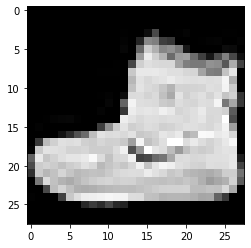

(tensor(1.), tensor(0.))

In [4]:
image: t.Tensor = training_data[0][0]
plt.imshow(image.permute(1, 2, 0), cmap="gray")
plt.show()
image.max(), image.min()

In [5]:
def to_2dim(item: Union[int, Tuple[int, int]]) -> Tuple[int, int]: 
    return (item, item) if isinstance(item, int) else tuple(item)

In [6]:
class Conv2dAutoPad(nn.Conv2d):
	def __init__(self, in_channels: int,
				 out_channels: int,
				 kernel_size: Union[int,Tuple[int, int]], 
			  	 stride:Union[int,Tuple[int, int]] =1,
				 dilation: Union[int,Tuple[int, int]] =1, 
				 groups: int =1,
				 bias: bool =True,
				 device=None,
				 dtype=None) -> None:
	 
		super().__init__(in_channels,
						 out_channels,
						 kernel_size,
						 stride,
						 dilation=dilation,
						 groups=groups,
						 bias=bias,
						 device=device,
						 dtype=dtype)
  
		self.padding = (0,0)
		self.auto_padding = sum(list(map(lambda x: (x//2, max(x//2 - 1 + (x&1), 0)), self.kernel_size[::-1])), ())
  
	def forward(self, X: t.Tensor):
		padded = F.pad(X, self.auto_padding)
		return super().forward(padded)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', auto_padding={self.auto_padding}'
		return base + s

In [7]:
class ConvTranspose2dAutoPad(nn.ConvTranspose2d):
	def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int,Tuple[int, int]], 
              	 stride:Union[int,Tuple[int, int]] =1,
                 dilation: Union[int,Tuple[int, int]] =1, 
                 groups: int =1,
                 bias: bool =True,
                 device=None,
                 dtype=None) -> None:
     
		super().__init__(in_channels,
                         out_channels,
                         kernel_size,
                         stride,
                         dilation=dilation,
                         groups=groups,
                         bias=bias,
                         device=device,
                         dtype=dtype)
		self.padding = (0,0)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1 + (x&1), 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor, output_size: List[int]):
		x, y = output_size[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X, output_size)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

In [8]:
class MaxPool2dAutoPad(nn.MaxPool2d):
	def __init__(self, kernel_size:  
				 Union[int,Tuple[int, int]],
				 stride: Union[int,Tuple[int, int]] = None,
			  	 dilation: Union[int,Tuple[int, int]] = 1,
				 return_indices: bool = False) -> None:
			
		super().__init__(kernel_size, 
						 stride,
						 dilation=dilation,
						 return_indices=return_indices,
						 ceil_mode=True)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1, 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor):
		x, y = X.shape[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

In [9]:
class MaxUnPool2dAutoPad(nn.MaxUnpool2d):
	def __init__(self, kernel_size:  
                 Union[int,Tuple[int, int]],
                 stride: Union[int,Tuple[int, int]] = None) -> None:
		    
		super().__init__(kernel_size, 
                         stride)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1, 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor, indices: t.Tensor, output_size:List[int]):
		x, y = output_size[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X, indices, output_size)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

In [10]:
class Activations:
	_modules: Dict[str, Callable[[],nn.Module]] = {
		'relu': lambda: nn.ReLU(False),
		'prelu-1':lambda: nn.PReLU(),
		'prelu-3':lambda: nn.PReLU(3),
		'prelu-8':lambda: nn.PReLU(8),
		'prelu-16':lambda: nn.PReLU(16),
		'prelu-32':lambda: nn.PReLU(32),
		'prelu-64':lambda: nn.PReLU(64),
		'prelu-128':lambda: nn.PReLU(128),
		'prelu-256':lambda: nn.PReLU(256),
		'prelu-512':lambda: nn.PReLU(512),
		'prelu-1024':lambda: nn.PReLU(1024),
		'leaky-relu':lambda: nn.LeakyReLU(),
		'tanh':lambda: nn.Tanh(),
		'selu':lambda: nn.SELU(False),
		'sigmoid':lambda: nn.Sigmoid(),
		'leaky-relu-01':lambda:nn.LeakyReLU(0.1),
		'leaky-relu-001':lambda:nn.LeakyReLU(),
		'leaky-relu-02':lambda:nn.LeakyReLU(0.2),
		'leaky-relu-005':lambda:nn.LeakyReLU(0.05)
	}
 
	@classmethod
	def get(cls, activation): return Activations._modules.get(activation, lambda: nn.Identity())()

In [11]:
class ConvDownSampleBlock(nn.Module):
	def __init__(self,kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
					activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
					groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
					device=None, dtype=None):
		super().__init__()
		self.activation_layer = Activations.get(activation)
		self.last_indices: t.Tensor =None
		self.last_conv_in_shape: Tuple[int, ...] =None
		self.last_pool_in_shape: Tuple[int, ...] =None
		stride = to_2dim(stride)
		kernel_size = to_2dim(kernel_size)
		self.pooling_applicable = bool(pooling_kernel)
  
		if self.pooling_applicable:
			pooling_kernel = to_2dim(pooling_kernel)
   
		self.conv = Conv2dAutoPad(in_features, out_features, kernel_size, stride=stride if not self.pooling_applicable else tuple(np.ones_like(stride).tolist()),
						 groups=groups, device=device, dtype=dtype)
		self.pooling = MaxPool2dAutoPad(pooling_kernel, stride, return_indices=True) if self.pooling_applicable else nn.Identity()
		self.bn = nn.BatchNorm2d(out_features)
  
	def forward(self, x:t.Tensor):
		self.last_conv_in_shape = x.shape 
		x = self.conv(x)
		#print("CONV:", x.shape, self.last_conv_in_shape)

		x = self.bn(self.activation_layer(x))
		if self.pooling_applicable:
			old = x
			self.last_pool_in_shape = old.shape
			x, self.last_indices = self.pooling(x)
			#print("POOLING:", old.shape, self.last_indices.shape)
			return x
		return self.pooling(x)

In [12]:
def conv_downsample(kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
                    activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
                    groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
                    device=None, dtype=None):
    return ConvDownSampleBlock(kernel_size, in_features, out_features, activation, stride, groups, pooling_kernel, device, dtype)

In [13]:
class ConvUpSampleBlock(nn.Module):
	def __init__(self, kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
				  activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
				  groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
				  device=None, dtype=None):
		super().__init__()
		stride = to_2dim(stride)
		kernel_size = to_2dim(kernel_size)
		self.pooling_applicable = bool(pooling_kernel)

		if self.pooling_applicable:
			pooling_kernel = to_2dim(pooling_kernel)
   
		self.unpooling = MaxUnPool2dAutoPad(pooling_kernel, stride) if self.pooling_applicable else nn.Identity()
		self.deconv = ConvTranspose2dAutoPad(in_features, out_features, kernel_size, stride=stride if not self.pooling_applicable else tuple(np.ones_like(stride).tolist()),
							 groups=groups, device=device, dtype=dtype)
		self.activation_layer = Activations.get(activation)
		self.bn = nn.BatchNorm2d(out_features)
  
	def forward(self, x:t.Tensor, expected_shape: Tuple[int, ...], indices:Optional[t.Tensor] = None, expected_pool_shape: Optional[Tuple[int, ...]] = None):
		#if self.pooling_applicable: print("UNPOOLING:", x.shape, indices.shape)
		x = self.unpooling(x, indices, expected_pool_shape) if self.pooling_applicable else self.unpooling(x)
		#print("DECONV:", x.shape, expected_shape)

		x = self.deconv(x, output_size=expected_shape)

		x = self.activation_layer(x)
		return self.bn(x)
 

In [14]:
def conv_upsample(kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
                  activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
                  groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
                  device=None, dtype=None):
     
    return ConvUpSampleBlock(kernel_size, in_features, out_features, activation, stride, groups, pooling_kernel, device, dtype)

In [15]:
class EncoderBlock(nn.Module):
	def __init__(self, 
				 in_channels: int,
			  	 block_channels: List[int], 
			  	 kernels: List[Union[int, Tuple[int, int]]],
			  	 pool_kernels: List[Union[int, Tuple[int, int]]] = None,
				 strides: Union[Union[int, Tuple[int, int]], 
								List[Union[int, Tuple[int, int]]]] =2,
				 activation: str ='relu',
				 groups: int =1,
				 device=None,
				 dtype=None) -> None:
		super().__init__()
		self.in_channels = in_channels
		channels = [in_channels] + block_channels
  
		assert len(kernels) == len(block_channels)
  
		self.indices = []
		self.conv_in_sizes = []
		self.pool_in_sizes = []
		self.pooling_applicable = True
		
		if not pool_kernels:
			pool_kernels = [None] * len(kernels)
			self.pooling_applicable = False
		  
		if isinstance(strides, list) and len(strides) != len(kernels): 
			raise Exception(f"Invalid dimensions of stride list: got {len(strides)}, expected {len(kernels)}")
		elif not isinstance(strides, list): strides = [strides] * len(kernels)
  
		block_ctor = partial(conv_downsample, 
					   		 activation=activation, 
						  	 groups=groups, 
							 device=device, 
							 dtype=dtype)
  
		self.block = nn.ModuleList(
				[block_ctor(kernel_size=kernel, 
				  			  in_features=in_features, 
					   		  out_features=out_features, 
						   	  stride=stride, 
							  pooling_kernel=pool_kernel)
				 for stride, in_features, out_features, pool_kernel, kernel in\
					zip(strides, channels[:-1], channels[1:], pool_kernels, kernels)
			]
		)
  
	def forward(self, x: t.Tensor):
		self.conv_in_sizes = []
		if self.pooling_applicable:
			self.indices = []
			self.pool_in_sizes = []

			for module in self.block:
				x = module(x)
				self.conv_in_sizes.append(module.last_conv_in_shape)
				self.pool_in_sizes.append(module.last_pool_in_shape)
				self.indices.append(module.last_indices)
    
			return x
		else:
			for module in self.block:
				self.conv_in_sizes.append(x.size())
				x = module(x)
			return x


In [16]:
class DecoderBlock(nn.Module):
	def __init__(self, 
				 out_channels: int,
			  	 block_channels: List[int], 
			  	 kernels: List[Union[int, Tuple[int, int]]],
			  	 pool_kernels: List[Union[int, Tuple[int, int]]] = None,
				 strides: Union[Union[int, Tuple[int, int]], 
								List[Union[int, Tuple[int, int]]]] =2,
				 activation: str ='relu',
				 groups: int =1,
				 device=None,
				 dtype=None) -> None:
		super().__init__()
		self.out_channels = out_channels
		channels = block_channels + [out_channels]
		assert len(kernels) == len(block_channels)
		self.pooling_applicable = True
		
		if not pool_kernels:
			pool_kernels = [None] * len(kernels)
			self.pooling_applicable = False
		if isinstance(strides, list) and len(strides) != len(kernels): 
			raise Exception(f"Invalid dimensions of stride list: got {len(strides)}, expected {len(kernels)}")
		elif not isinstance(strides, list): strides = [strides] * len(kernels)
  
		block_ctor = partial(conv_upsample, 
					   		 activation=activation, 
						  	 groups=groups, 
							 device=device, 
							 dtype=dtype)
  
		self.block = nn.ModuleList(
				[block_ctor(kernel_size=kernel, 
				  			 in_features=in_features, 
					   		 out_features=out_features, 
						   	 stride=stride, 
							 pooling_kernel=pool_kernel)
				 for stride, in_features, out_features, pool_kernel, kernel in\
					zip(strides, channels[:-1], channels[1:], pool_kernels, kernels)
			]
		)
  
	def forward(self, x: t.Tensor, expected_sizes:List[Tuple[int, ...]], indices: Optional[List[t.Tensor]] = None, expected_pool_sizes:Optional[List[Tuple[int, ...]]] = None):
		if self.pooling_applicable:
			for module in self.block:
				s, i, p_s = expected_sizes.pop(), indices.pop(), expected_pool_sizes.pop()
				x = module(x, s, i, p_s)
			return x
		else:
			for module in self.block:
				x = module(x, expected_sizes.pop())
			return x

In [17]:
class BottleNeckBlock(nn.Module):
	def __init__(self, in_shape: Tuple[int,...], latent_space, activation ='relu'):
		super().__init__()
		self.features = latent_space
		in_channels = np.prod(in_shape)
		self.block = nn.Sequential(
			nn.Flatten(),
			nn.Linear(in_channels, self.features),
			Activations.get(activation),
			nn.Linear(self.features, in_channels),
			Activations.get(activation)
		)

	def forward(self, x:t.Tensor):
		shape = x.shape
		x = self.block(x)
		x = x.reshape(shape)
		return x

In [18]:
class AutoEncoder(nn.Module):
	def __init__(self,
				 in_shape: Tuple[int, int, int],
				 bottle_neck_features: int,
			  	 block_channels: List[int], 
			  	 kernels: List[Union[int, Tuple[int, int]]],
			  	 pool_kernels: List[Union[int, Tuple[int, int]]] = None,
				 strides: Union[Union[int, Tuple[int, int]], 
								List[Union[int, Tuple[int, int]]]] =2,
				 activation: str ='relu',
				 groups: int =1,
				 device=None,
				 dtype=None):
		
		super().__init__()
		in_channels = in_shape[0]
		decoder_channels = block_channels[::-1]
		decoder_kernels = kernels[::-1]
		decoder_strides = strides[::-1] if not isinstance(strides, int) else strides
		self.pooling_applicable = bool(pool_kernels)
		decoder_pool_kernels = pool_kernels[::-1] if self.pooling_applicable else None
		
		self.encoder =  EncoderBlock(
			in_channels,
			block_channels,
			kernels,
			pool_kernels,
			strides,
			activation,
			groups,
			device,
			dtype
		)
		st = [strides] * len(kernels) if isinstance(strides, int) or strides == (strides[0], strides[1]) else strides
		x, y = in_shape[-2:]

		for s in st:
			
			if isinstance(s, int):
				s = (s, s)
			x = max(((x // s[0]) + (x&1)), 1)
			y = max(((y // s[1]) + (y&1)), 1)
  
		self.bottle_neck = BottleNeckBlock(
			(block_channels[-1], x, y),
			bottle_neck_features, 
	  		activation
		)
		self.decoder = DecoderBlock(
			in_channels,
			decoder_channels,
			decoder_kernels,
			decoder_pool_kernels,
			decoder_strides,
			activation,
		   	groups,
			device,
			dtype
		)
		
		
	def forward(self, x: t.Tensor):
		if self.pooling_applicable:
			x = self.encoder(x)
			x = self.bottle_neck(x)
			x = self.decoder(x, self.encoder.conv_in_sizes, self.encoder.indices, self.encoder.pool_in_sizes)
		else:
			x = self.encoder(x)
			x = self.bottle_neck(x)
			x = self.decoder(x, self.encoder.conv_in_sizes)
		return x
	

In [19]:
def update_loop(loop: tqdm, metrics: Dict[str, float]):
	loop.set_postfix(metrics)
	return tuple(metrics.values())


In [20]:
def fit(model: nn.Module, loss: nn.Module, optimizer: optim.Optimizer, train_data: Dataset, 
		epochs=1, batch_size=32, validation_batch_size=32, validation_data:Dataset=None, 
		model_to_save: nn.Module=None, name: str="model", 
        save_model_on_metrics: List[str]=['Loss']):
    
	assert batch_size > 0 and epochs > 0
	import string
	remove_punctuation = str.maketrans(string.punctuation, '_'*len(string.punctuation))
	device = "cuda" if t.cuda.is_available() else "cpu"
		
	loop = tqdm(range(epochs), position=0)
 
	training_data_loader =DataLoader(train_data, batch_size, shuffle=True)
  
	evaluate = validation_data is not None
	test_data_loader = DataLoader(validation_data, 
                                  validation_batch_size, 
                                  shuffle=True) if evaluate else None
 
	basic_metrics = ['Loss']
	metrics = OrderedDict({metric:(0.0 if 'Loss' not in metric else np.inf) for metric in basic_metrics})
 
	if evaluate:
		metrics = {**metrics, **{f"Eval. {key}":value for key, value in metrics.items()}}	
  
	if any([observable for observable in save_model_on_metrics if observable not in metrics]): 
		raise Exception(f"Not all provided metric can be computed, supported: {list(metrics.keys())}")
   
	model = model.to(device)
 
	if model_to_save is None: model_to_save = model
 
	def __turn_on_off_running_stats(model: nn.Module, on=True):
		for m in model.modules():
			if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
				m.track_running_stats = on
    
	best_metrics = {metric:(0.0 if 'Loss' not in metric else np.inf) for metric in save_model_on_metrics}
	comp_metrics = {metric:(lambda old, new: old < new) if 'Loss' not in metric else (
        lambda old, new: old > new) for metric in save_model_on_metrics}
	short_metrics = {metric: metric.translate(remove_punctuation)
                     .replace('_', '')
                     .replace(' ', '_') for metric in save_model_on_metrics}
	#__turn_on_off_running_stats(model, False)
	def __eval(data_loader: DataLoader) -> Tuple[t.Tensor]:
		
		with t.no_grad():
			model.eval()

			epoch_losses = t.zeros(len(data_loader), requires_grad=False).to(device)

			for idx, item in enumerate(data_loader):
				x: t.Tensor = item[0]

				y: t.Tensor = item[0].clone().detach()
				x = x.to(device)
				y = y.to(device)
				y_pred: t.Tensor = model(x)
				loss_tensor: t.Tensor = loss(y_pred, y)

				epoch_losses[idx] = (loss_tensor)
			_loss = epoch_losses.mean()
			
		return (_loss.item(),)
 
	def __step(data_loader: DataLoader, validation_data=None, evaluate=False) -> Tuple[t.Tensor, ...]:
		epoch_losses = t.zeros(len(data_loader), requires_grad=False).to(device)
		model.train()
		for idx, item in enumerate(data_loader):
			x: t.Tensor = item[0]
			y: t.Tensor = item[0].clone().detach()
			x = x.to(device)
			y = y.to(device)
	
			y_pred: t.Tensor = model(x)
			loss_tensor: t.Tensor = loss(y_pred, y)
	
			optimizer.zero_grad()
			loss_tensor.backward()
			optimizer.step()
			
			epoch_losses[idx] = (loss_tensor).item()
   
			metric_vals = [loss_tensor.item()]
			metrics.update({key:val for key, val in zip(basic_metrics, metric_vals)})
			update_loop(loop, metrics)
   
		_loss = epoch_losses.mean()
		metric_vals = [_loss.item()]
		metrics.update({key:val for key, val in zip(basic_metrics, metric_vals)})
  
		if evaluate:
			eval_metrics = __eval(validation_data)
			metrics.update({f"Eval. {key}":val for key, val in zip(basic_metrics, eval_metrics)})

		for metric in save_model_on_metrics:
            
			if comp_metrics[metric](best_metrics[metric], metrics[metric]):
				
				best_metrics[metric] = metrics[metric]
				print(f'Improved {metric} to {best_metrics[metric]}')
				t.save(model_to_save, f'{name}_{short_metrics[metric]}.pth')
			
		return metrics

	metrics_tensor = t.as_tensor([update_loop(loop, __step(training_data_loader, 
                                                           test_data_loader, 
                                                           evaluate)) for _ in loop])
	
	history: Dict[str, List[float]] = {}
	for i in range(len(basic_metrics)):
		history[basic_metrics[i]] = metrics_tensor[:, i].tolist()
  
	if evaluate:
		for i in range(len(basic_metrics), 0, -1):
			history["Eval. " + basic_metrics[-i]] = metrics_tensor[:, -i].tolist()

	return history

In [34]:
def plot_metrics(metric_names: List[str], metrics: Dict[str, List[float]]):
	metric_count = len(metric_names)
	_, axes = plt.subplots(1,metric_count, figsize= (metric_count*5, metric_count))
	eval_metrics = 2*metric_count == len(metrics)
	axes: Dict[str, Axes] = {metric_name:ax for metric_name, ax in zip(metric_names, axes.flat)} if metric_count > 1 else {metric_names[0]:axes} 
	for metric in metric_names:
		ax = axes[metric]
		ax.set_title(f'History of {metric}')
		linspace = range(1, len(metrics[metric]) + 1)
		ax.plot(linspace, metrics[metric])
		ax.set_xlabel('Epochs')
		ax.set_ylabel(metric)
		if eval_metrics:
			ax.plot(linspace, metrics[f'Eval. {metric}'])
			ax.legend(['Training', 'Evaluation'])
		else: ax.legend(['Training'])
	plt.show()

In [22]:
model = AutoEncoder((training_data[0][0].shape), 100, [64, 128, 256], [3,3,3])#, [2,2,2])

In [23]:
print(model)

AutoEncoder(
  (encoder): EncoderBlock(
    (block): ModuleList(
      (0): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(1, 64, kernel_size=(3, 3), stride=(2, 2), auto_padding=(1, 1, 1, 1))
        (pooling): Identity()
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(64, 128, kernel_size=(3, 3), stride=(2, 2), auto_padding=(1, 1, 1, 1))
        (pooling): Identity()
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(128, 256, kernel_size=(3, 3), stride=(2, 2), auto_padding=(1, 1, 1, 1))
        (pooling): Identity()
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (bottle_neck): BottleN

In [24]:
history = fit(model, nn.L1Loss(), optim.Adam(model.parameters(), lr=0.01), epochs=10, train_data=training_data, batch_size=64, validation_data=test_data, validation_batch_size=64, name="autoencoder_fashion_mnist", save_model_on_metrics=["Eval. Loss"])

  0%|          | 0/10 [00:00<?, ?it/s]

Improved Eval. Loss to 0.06692253798246384
Improved Eval. Loss to 0.05009987950325012
Improved Eval. Loss to 0.04598460718989372
Improved Eval. Loss to 0.043587952852249146
Improved Eval. Loss to 0.04159679636359215
Improved Eval. Loss to 0.03957703337073326
Improved Eval. Loss to 0.036910027265548706


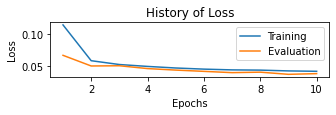

In [35]:
plot_metrics(["Loss"], history)

torch.Size([28, 28]) torch.float32


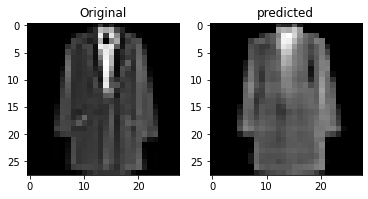

torch.Size([28, 28]) torch.float32


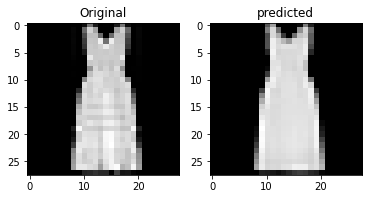

torch.Size([28, 28]) torch.float32


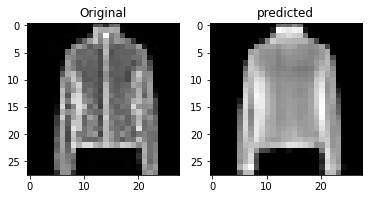

torch.Size([28, 28]) torch.float32


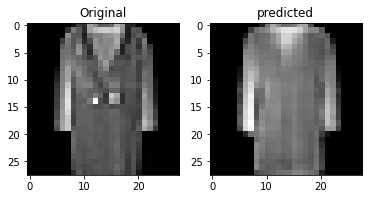

torch.Size([28, 28]) torch.float32


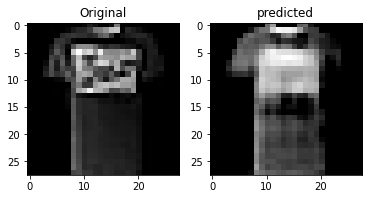

torch.Size([28, 28]) torch.float32


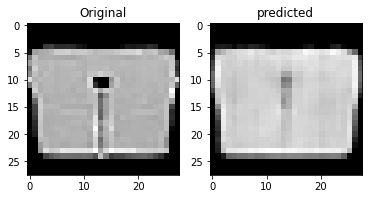

torch.Size([28, 28]) torch.float32


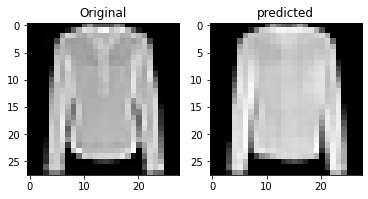

torch.Size([28, 28]) torch.float32


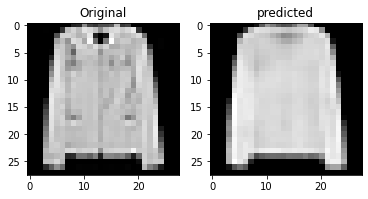

torch.Size([28, 28]) torch.float32


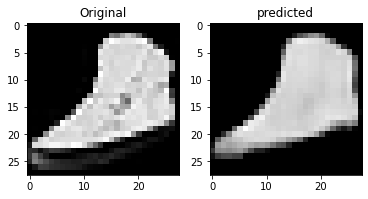

torch.Size([28, 28]) torch.float32


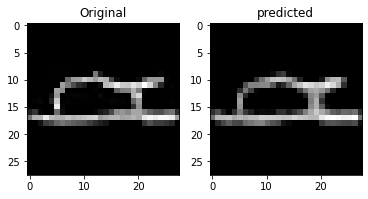

In [36]:
d = DataLoader(training_data, 1, shuffle=True)
d_iter = iter(d)
with t.no_grad():
	for i in range(10):
		x: t.Tensor = next(d_iter)[0].to("cuda")
		x_hat: t.Tensor = model(x)
		x_hat = x_hat.to(device="cpu", dtype=t.float32).squeeze(1).squeeze(0)
		print(x_hat.shape, x_hat.dtype)
		_, axis = plt.subplots(1, 2)
		axis[0].imshow(x.cpu().squeeze(1).squeeze(0), cmap='gray')
		axis[0].set_title("Original")
		axis[1].imshow(x_hat, cmap='gray')
		axis[1].set_title("predicted")
		plt.show()

In [37]:
model = AutoEncoder((training_data[0][0].shape), 100, [64, 128, 256], [3,3,3], [2,2,2])

In [38]:
model

AutoEncoder(
  (encoder): EncoderBlock(
    (block): ModuleList(
      (0): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(1, 64, kernel_size=(3, 3), stride=(1, 1), auto_padding=(1, 1, 1, 1))
        (pooling): MaxPool2dAutoPad(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True, x_padding=(0, 1), y_padding=(0, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(64, 128, kernel_size=(3, 3), stride=(1, 1), auto_padding=(1, 1, 1, 1))
        (pooling): MaxPool2dAutoPad(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True, x_padding=(0, 1), y_padding=(0, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvDownSampleBlock(
        (activation_layer): ReLU()
        (conv): Conv2dAutoPad(128, 25

In [ ]:
history = fit(model, nn.L1Loss(), optim.Adam(model.parameters(), lr=0.01), epochs=10, train_data=training_data, batch_size=64, validation_data=test_data, validation_batch_size=64, name="autoencoder_fashion_mnist", save_model_on_metrics=["Eval. Loss"])

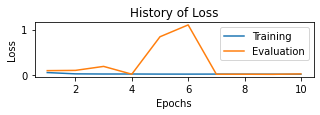

In [40]:
plot_metrics(["Loss"], history)

torch.Size([28, 28]) torch.float32


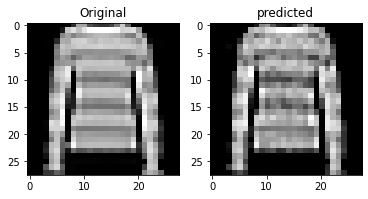

torch.Size([28, 28]) torch.float32


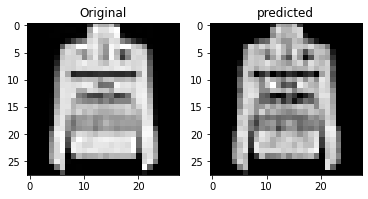

torch.Size([28, 28]) torch.float32


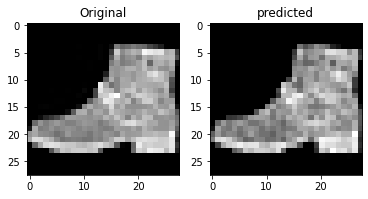

torch.Size([28, 28]) torch.float32


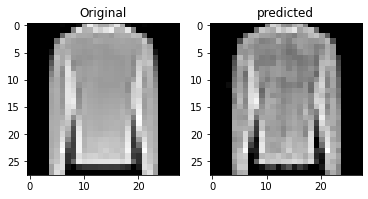

torch.Size([28, 28]) torch.float32


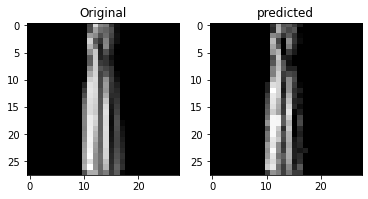

torch.Size([28, 28]) torch.float32


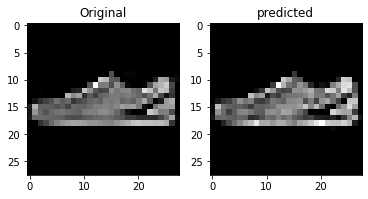

torch.Size([28, 28]) torch.float32


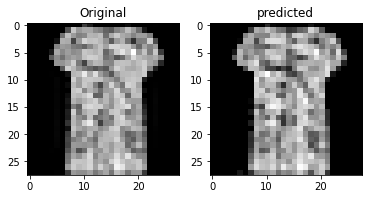

torch.Size([28, 28]) torch.float32


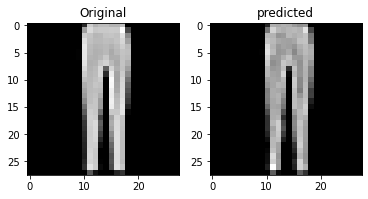

torch.Size([28, 28]) torch.float32


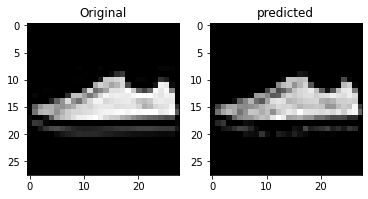

torch.Size([28, 28]) torch.float32


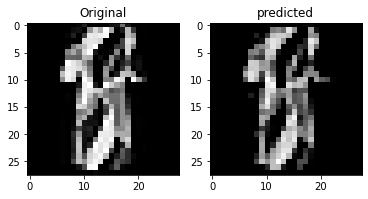

In [41]:
d = DataLoader(training_data, 1, shuffle=True)
d_iter = iter(d)
with t.no_grad():
	model.eval()
	for i in range(10):
		x: t.Tensor = next(d_iter)[0].to("cuda")
		x_hat: t.Tensor = model(x)
		x_hat = x_hat.to(device="cpu", dtype=t.float32).squeeze(1).squeeze(0)
		print(x_hat.shape, x_hat.dtype)
		_, axis = plt.subplots(1, 2)
		axis[0].imshow(x.cpu().squeeze(1).squeeze(0), cmap='gray')
		axis[0].set_title("Original")
		axis[1].imshow(x_hat, cmap='gray')
		axis[1].set_title("predicted")
		plt.show()